In [139]:
import numpy as np
import pandas as pd
import ast
import glob
import imageio.v3 as iio
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy import stats
import os

In [2]:
# read in data frame with corresponding trial and image data
df = (
    pd.read_csv("imagedf.csv", usecols=range(1,12))
    .query("subjID != 'connect-67550B0A8CC84323BF8A30B2D0D33B6B' & imageID != 'connect-BA366CE24A6245D0BFF165BA41E4F395_img64.png'") #remove participant missing images
)

# calculate number of strokes from drawnlines arrays
def countStrokes(linesString):
    return len(ast.literal_eval(linesString))

df = (
    df
    .assign(numStrokes = df.apply(lambda x: countStrokes(x['drawnLines']), axis=1))
)


print(df.head())

                                     subjID trainingCond         levelID  \
0  connect-F7D40967AFF441E08EE288EBFBFBB8E6       narrow  contain_corner   
1  connect-F7D40967AFF441E08EE288EBFBFBB8E6       narrow  contain_corner   
2  connect-F7D40967AFF441E08EE288EBFBFBB8E6       narrow  contain_corner   
3  connect-F7D40967AFF441E08EE288EBFBFBB8E6       narrow      block_long   
4  connect-F7D40967AFF441E08EE288EBFBFBB8E6       narrow      block_long   

   gravX trialPart  numTrial  numAttempts  \
0    0.0  training         0            0   
1    0.0  training         0            1   
2    0.0  training         0            2   
3    0.0  training         1            0   
4    0.0  training         1            1   

                                          drawnLines  success  \
0  [[{'x': 32, 'y': 140}, {'x': 56, 'y': 140}, {'...     fail   
1  [[{'x': 14, 'y': 166}, {'x': 30, 'y': 169}, {'...     fail   
2  [[{'x': 14, 'y': 166}, {'x': 30, 'y': 169}, {'...  success   
3  [[{'x': 3

# Convert image to binary

In [3]:
# function converts image to binary and return edited image
def toBinary(image):
    # convert image to numpy array
    img_array = np.array(image)

    # define green line that we are targeting
    target_color = np.array([0, 170, 0, 255])

    # binary mask where pixels matching the target color = True
    mask = np.all(img_array == target_color, axis=-1)
    
    # set pixels matching the target color to black and everything else to white
    img_array[mask] = [0, 0, 0, 255]  # Black
    img_array[~mask] = [255, 255, 255, 255]  # White

    # convert the NumPy array back to an image
    result_img = Image.fromarray(img_array)
    
    return result_img

In [4]:
# convert all images to binary
Dict = {}
for im_path in glob.glob("../../game1/data/img/expt/*/*.png"):
    # get subject ID info
#     subjID = im_path.split("connect-",1)[1][0:10]
    
    # get image ID info
    imageID = im_path.split("expt/",1)[1][41:]
#     dfrow = df[df['imageID'].str.contains(imageID)]
#     print(dfrow.iloc[0]['levelID'])
    
    # open each image
    img = Image.open(im_path)
    
    # convert images to binary
    new_img = toBinary(img)
    
    # save edited images to dictionary
    Dict[imageID] = new_img
    
    # show image
#     imgplot = plt.imshow(new_img)
#     plt.show()


# Measure mutual information

In [11]:
def mutual_information(hgram):
    # Mutual information for joint histogram
    # Convert bins counts to probability values
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # marginal for x over y
    py = np.sum(pxy, axis=0) # marginal for y over x
    px_py = px[:, None] * py[None, :] # Broadcast to multiply marginals
    # Now we can do the calculation using the pxy, px_py 2D arrays
    nzs = pxy > 0 # Only non-zero pxy values contribute to the sum
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

def entropy(hgram):
    # Entropy for histogram
    p = hgram / np.sum(hgram)
    nzs = p > 0
    return -np.sum(p[nzs] * np.log(p[nzs]))

In [7]:
def compareImgs(img1, img2):
    s1 = Dict[img1]
    s2 = Dict[img2]
#     plt.imshow(np.hstack((s1, s2)))
    s1_arr = np.asarray(s1).ravel()
    s2_arr = np.asarray(s2).ravel()
    hist_2d, x_edges, y_edges = np.histogram2d(s1_arr,s2_arr,bins=20)
    return mutual_information(hist_2d)

In [12]:
def getEntropy(img):
    s = Dict[img]
    s_arr = np.asarray(s).ravel()
    hist, edges = np.histogram(s_arr, bins=20)
    return entropy(hist)

## Test mutual information across within-participant images

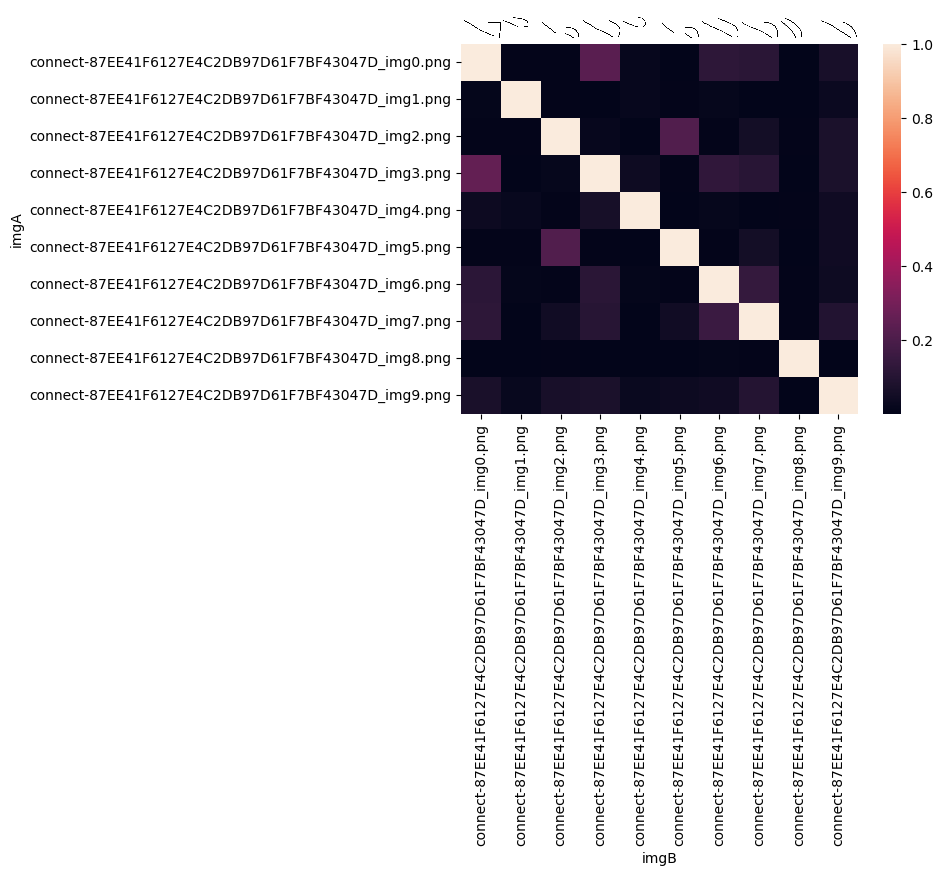

In [14]:
samplemidf = pd.DataFrame()
data_list = []
axis_imgs = []
subjdf = df[df['imageID'].str.contains('connect-87EE41F6127E4C2DB97D61F7BF43047D')]['imageID']
for a in subjdf[0:10]:
    axis_imgs.append(Dict[a])
    for b in subjdf[0:10]:
        row = {'imgA': a, 'imgB': b, 'mutualinfo': compareImgs(a, b), 'entropyA': getEntropy(a) }
        data_list.append(row) 

samplemidf = (
    pd.DataFrame(data_list)
    .assign(cond_mutualinfo = lambda x: x['mutualinfo'] / x['entropyA'])
)

infodf = samplemidf.pivot(index="imgA", columns="imgB", values="cond_mutualinfo") #or values = mutualinfo
ax = sns.heatmap(infodf)

tick_labels = ax.xaxis.get_ticklabels()


for i,im in enumerate(axis_imgs):
    ib = OffsetImage(im, zoom=.035)
    ib.image.axes = ax
    ab = AnnotationBbox(ib,
                    tick_labels[i].get_position(),
                    frameon=False,
                    box_alignment=(0.5, 0)
                    )
    ax.add_artist(ab)

## Calculate average image

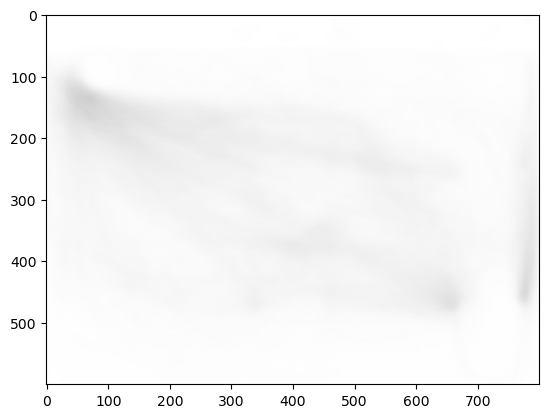

In [15]:
# average of all images
img_arrs = []
for d in Dict:
    img_arr = np.array(Dict[d])
    img_arrs.append(img_arr)

avg_arr = np.mean(np.array(img_arrs), axis=0)
result_img = Image.fromarray(avg_arr.astype(np.uint8))
plt.imshow(result_img)
result_img.save("fig/strokes/avgStroke.png")

contain_corner


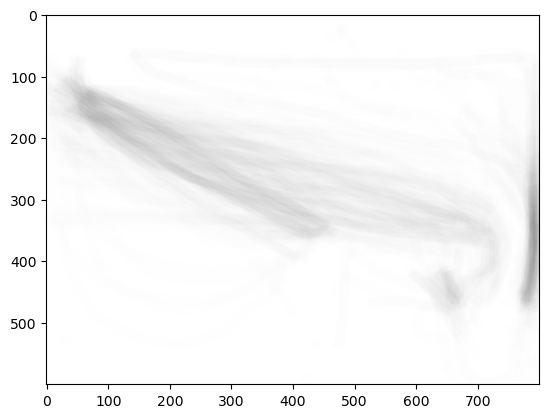

block_long


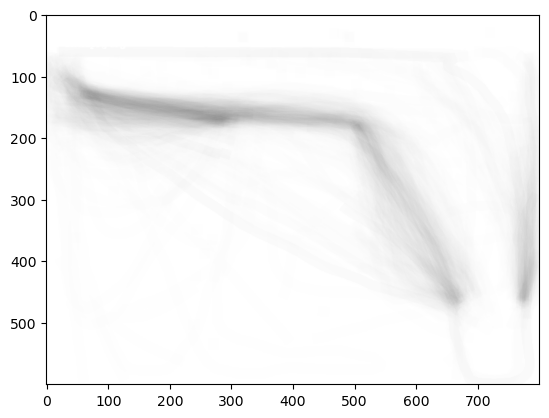

block_med


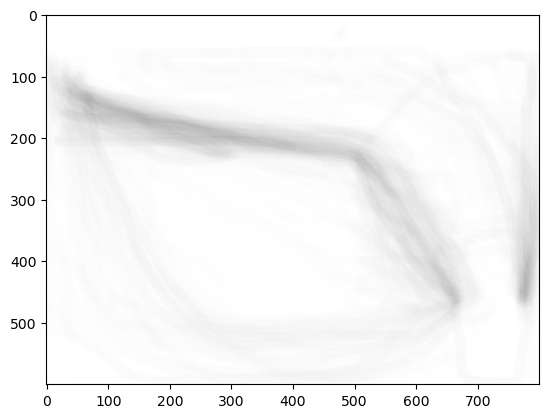

boomerang_middle


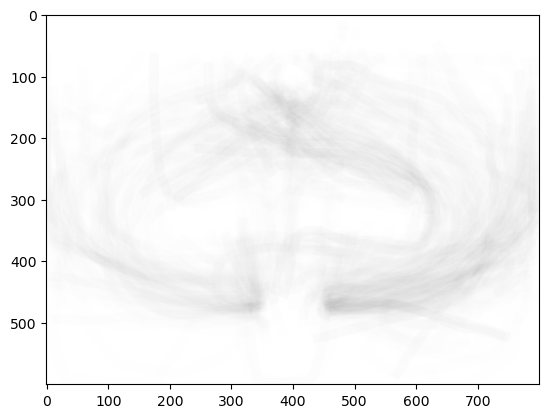

diagonal_descent


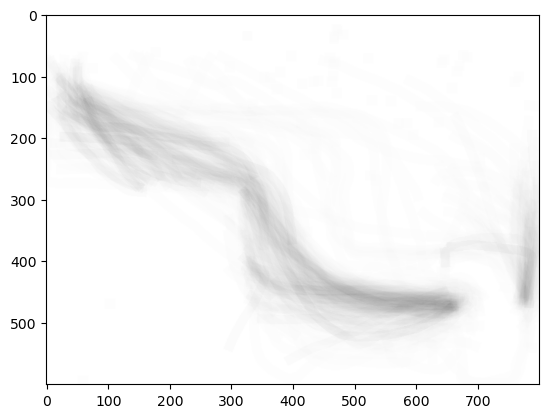

basic_drop


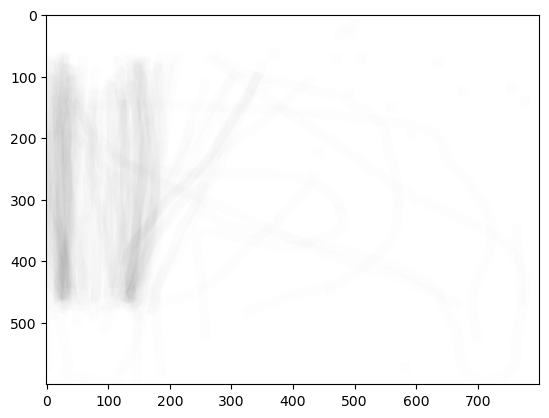

boomerang_left


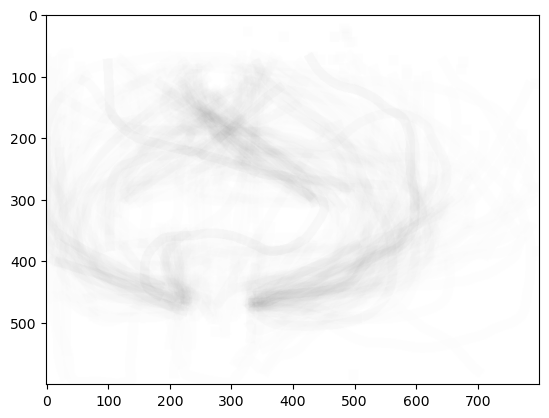

basic_flat


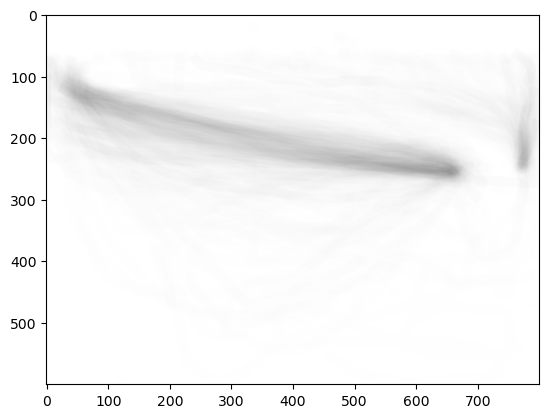

diagonal_ascent


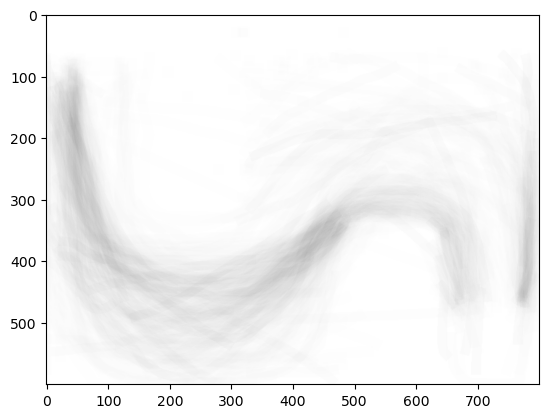

basic_far


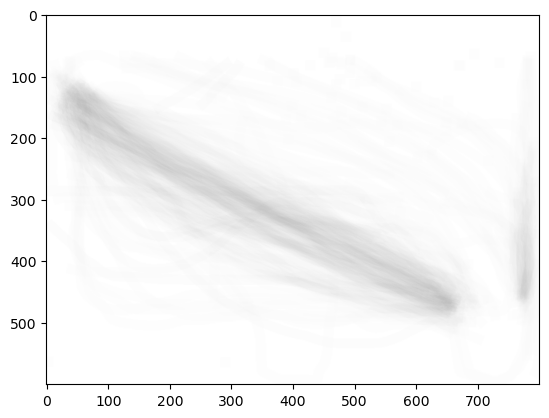

basic_steep


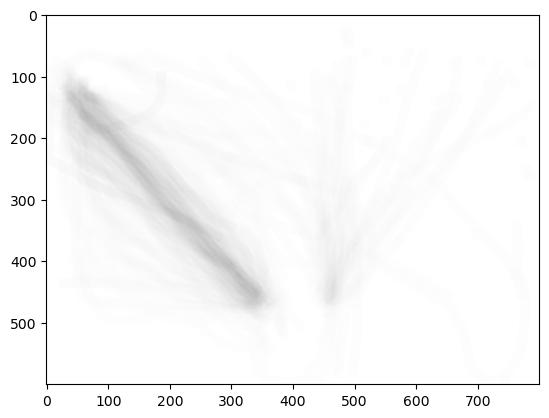

tunnel_narrow


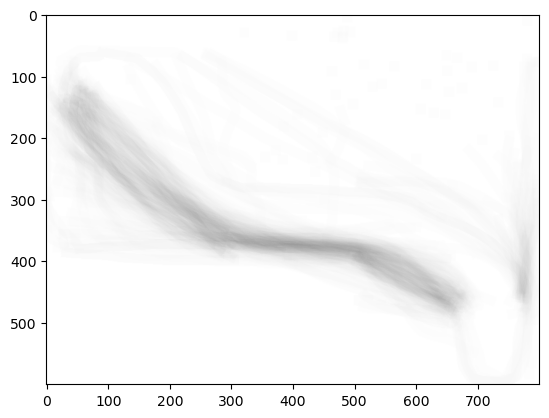

basic_short


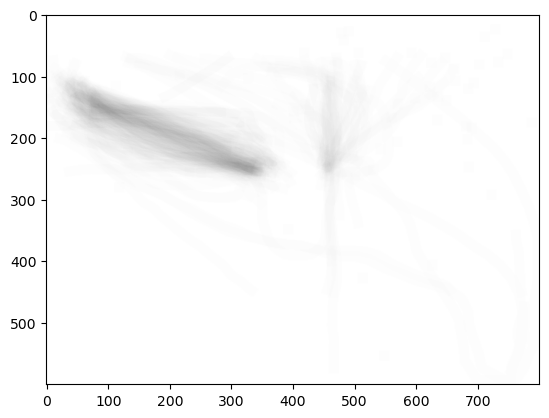

tunnel_wide


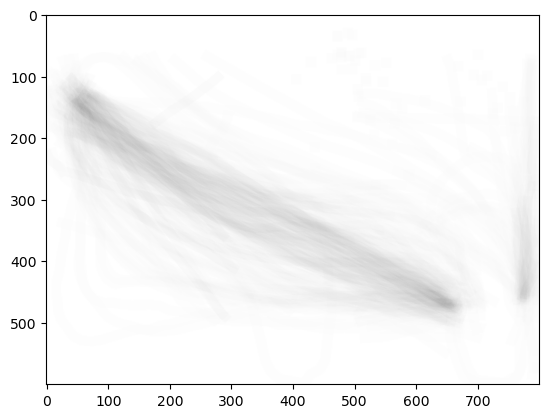

In [16]:
avgLevel = {}

for levelLabel in df['levelID'].unique():
    print(levelLabel)
    levelImgs = df[df['levelID'].str.contains(levelLabel)]['imageID']
    img_arrs = []
    for l in levelImgs:
        img_arr = np.array(Dict[l])
        img_arrs.append(img_arr)
    avgLevel[levelLabel] = np.mean(np.array(img_arrs), axis=0)
    result_img = Image.fromarray(avgLevel[levelLabel].astype(np.uint8))
    imgplot = plt.imshow(result_img)
    plt.show()
    result_img.save("fig/strokes/"+levelLabel+".png")

## Calculate mutual information from average images

### mutual information to average level image

In [17]:
all_mi_toLvl = []

for d in Dict:
    if len(df[df['imageID'].str.contains(d)]) > 0:
        s1 = Dict[d]
        s1_arr = np.asarray(s1).ravel()
        s1_levelID = df[df['imageID'].str.contains(d)]['levelID'].iloc[0]
        s2_arr = avgLevel[s1_levelID].ravel()
        hist_2d, x_edges, y_edges = np.histogram2d(s1_arr,s2_arr,bins=20)
        row = {'img': d, 'level':s1_levelID, 'mutualinfo': mutual_information(hist_2d)}
        all_mi_toLvl.append(row) 

/Users/lo2069/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


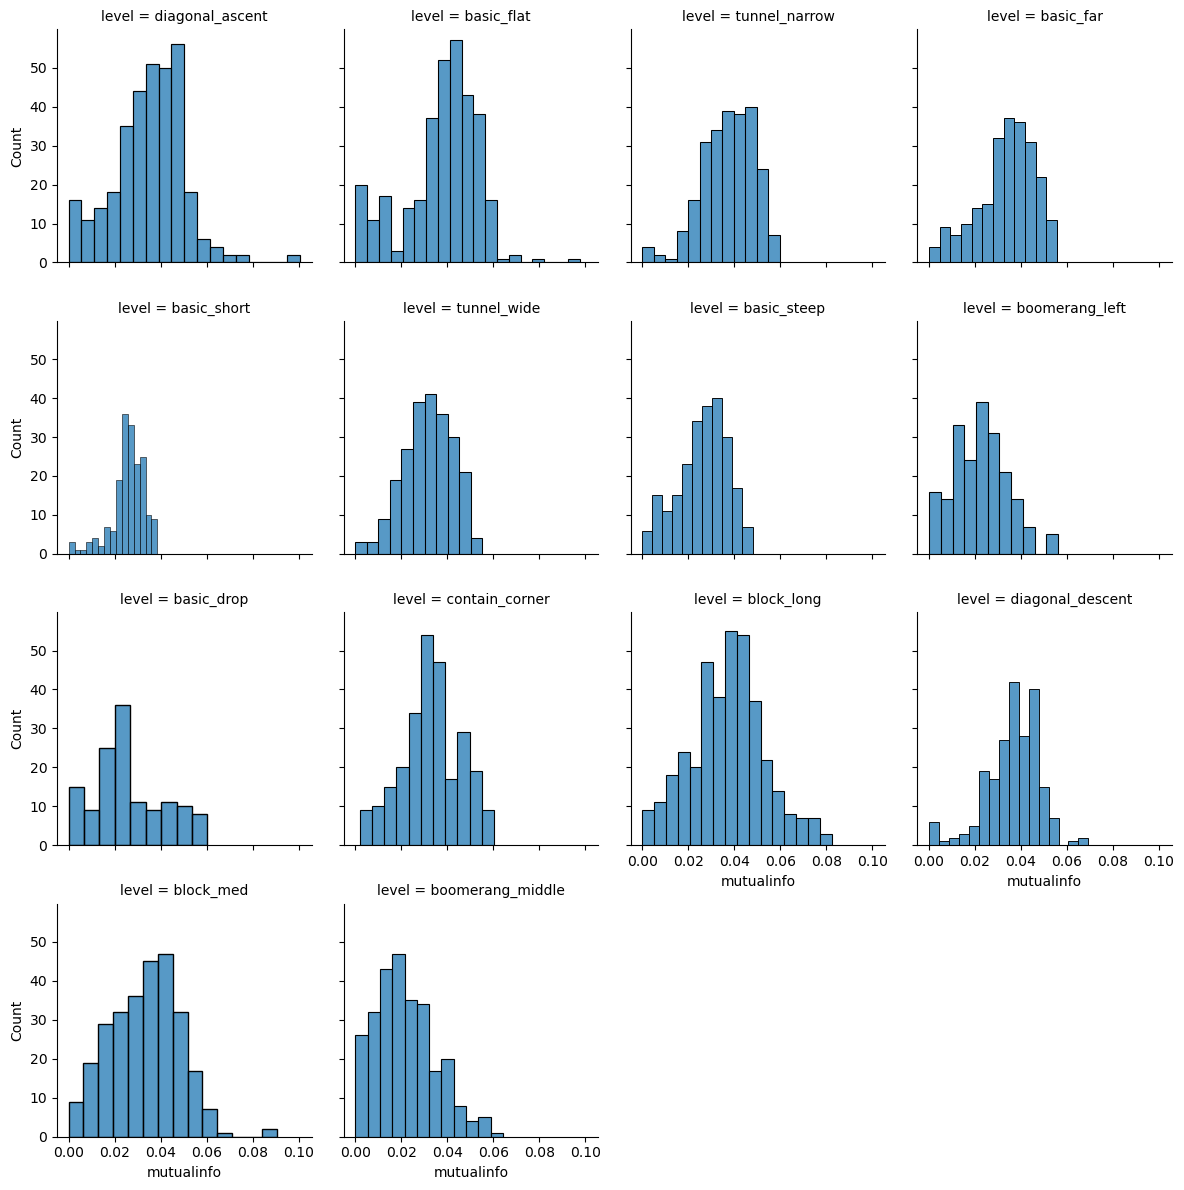

In [18]:
all_mi_toLvl_df = pd.DataFrame(all_mi_toLvl)
all_mi_toLvl_df.groupby('level').agg({'mutualinfo': ['mean','var']})

g = sns.FacetGrid(all_mi_toLvl_df, col="level", col_wrap=4)
g.map(sns.histplot, "mutualinfo")
g.savefig("fig/mi_levels.png")

In [19]:
# between variance - levels avg vs overall avg
bw_mi_toLvl = []
for a in avgLevel:
    s1 = avgLevel[a]
    s1_arr = np.asarray(s1).ravel()
    s2_arr = avg_arr.ravel()
    hist_2d, x_edges, y_edges = np.histogram2d(s1_arr,s2_arr,bins=20)
    row = {'level':a, 'mutualinfo': mutual_information(hist_2d)}
    bw_mi_toLvl.append(row) 

In [20]:
bw_mi_toLvl_df = pd.DataFrame(bw_mi_toLvl)

# between level variance
np.var(bw_mi_toLvl_df['mutualinfo'])
# more between level variance than within => levels produce distinctive solutions

0.006959938557271749

### entropy across all levels

In [21]:
# get entropy for each image by levelID
imgEntropy = []
for l in df['levelID'].unique():
    levelAtt = (
        df
        .query("levelID == @l")
        .groupby(["subjID","gravX"])
        .apply(lambda x: x.query("numAttempts == numAttempts.max()"))
        .loc[:, 'imageID']
    )
    
    for i in range(0,len(levelAtt)):
        img = levelAtt[i]
        row = { 'levelID':l, 'img': img, 'entropy': getEntropy(img) }
        imgEntropy.append(row)


/Users/lo2069/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


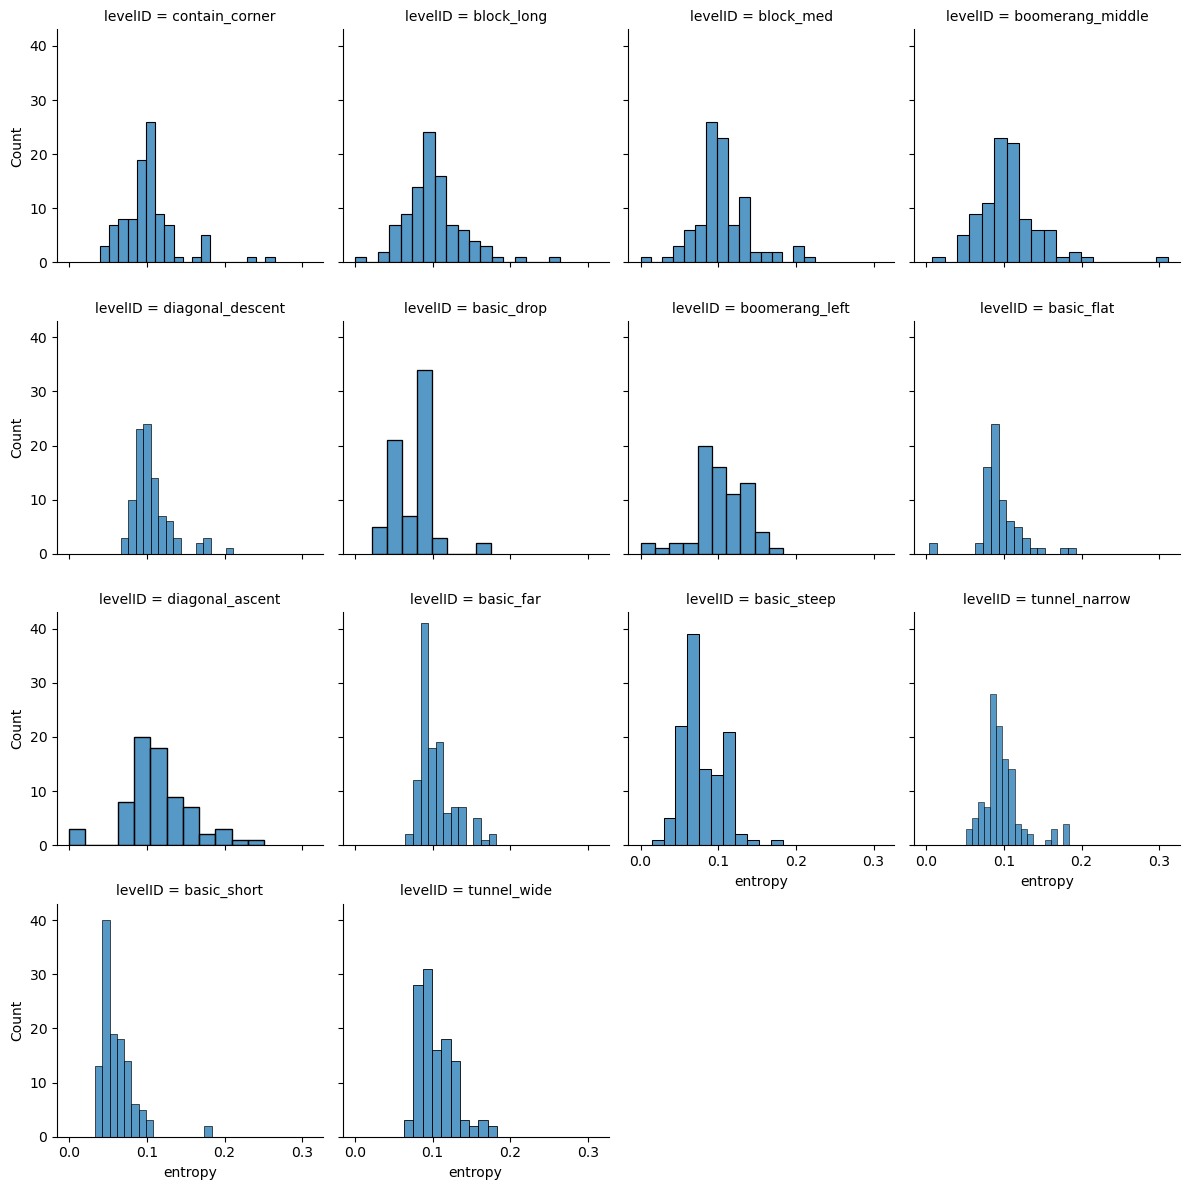

In [23]:
entropydf = pd.DataFrame(imgEntropy)

g = sns.FacetGrid(entropydf, col="levelID", col_wrap=4)
g.map(sns.histplot, "entropy")

### mutual information across all levels

In [24]:
# full mutual information between each trial
## matrix triangle for each level
MIbw = []
for l in df['levelID'].unique():
    levelAtt = (
        df
        .query("levelID == @l")
        .groupby(["subjID","gravX"])
        .apply(lambda x: x.query("numAttempts == numAttempts.max()"))
        .loc[:, 'imageID']
    )
    
    for s in range(0,len(levelAtt)):
        for t in range(s+1, len(levelAtt)): 
            imgA = levelAtt[s]
            imgB = levelAtt[t]
            row = { 'levelID':l, 'imgA': imgA, 'imgB': imgB, 'mutualinfo': compareImgs(imgA, imgB) }
            MIbw.append(row)

<Axes: xlabel='mutualinfo', ylabel='Count'>

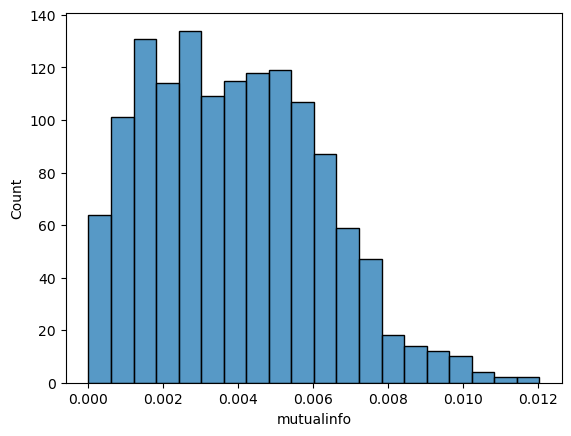

In [26]:
MIbw_combos = pd.DataFrame(MIbw)
MIbw_combos.to_csv("dfs/mutualinfo.csv")

MIbw_df = (
    MIbw_combos
    .set_index(['levelID', 'mutualinfo'])
    .stack()
    .reset_index(name='imageID')
    .groupby('imageID')
    .agg({'mutualinfo':'mean'})
)

sns.histplot(MIbw_df, x="mutualinfo")

In [57]:
# conditional mutual info
condMI_df = (
    MIbw_df
    .merge(entropydf, how='left', left_on="imageID", right_on="img")
    .assign(cond_mutualinfo = lambda x: x['mutualinfo']/x['entropy'])
    .rename(columns={'img':'imageID'})
    .drop(['mutualinfo', 'entropy'], axis=1)
)

<Axes: xlabel='cond_mutualinfo', ylabel='Count'>

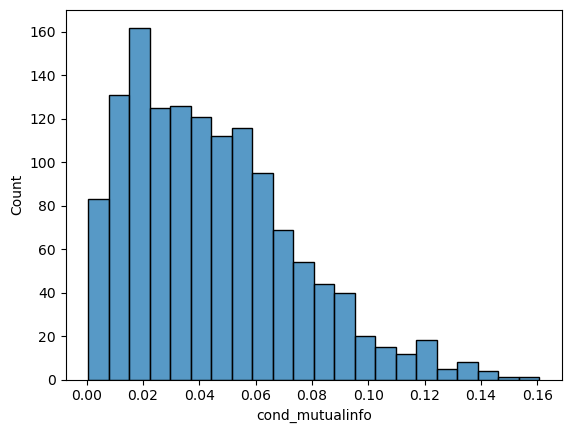

In [58]:
sns.histplot(condMI_df, x="cond_mutualinfo")

### retrieve amount of ink from pixel matrices

<Axes: xlabel='ink', ylabel='Count'>

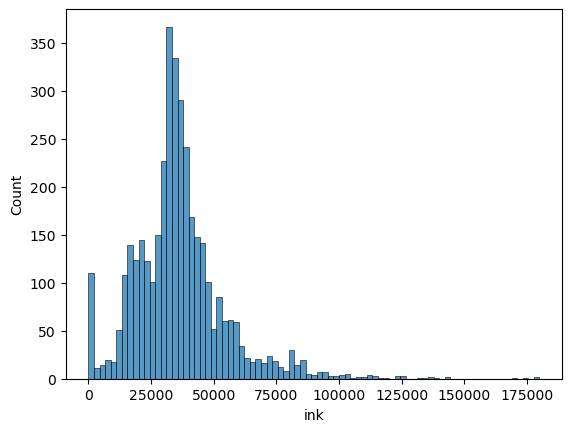

In [27]:
# calculate number of non-black pixels
inks = []
for i in Dict:
    si = Dict[i]
    ink = np.count_nonzero(np.array(si) != [255, 255, 255, 255])
    row = {'imageID': i, 'ink': ink}
    inks.append(row)

ink_df = pd.DataFrame(inks)
sns.histplot(ink_df, x="ink")

In [61]:
# merge amount of ink
trials = df.merge(ink_df, how="left", on="imageID")
# merge mutual information to avg level
trials = (
    trials
    .merge(all_mi_toLvl_df, how="left", left_on=["imageID", "levelID"], right_on=["img","level"])
    .rename(columns={'mutualinfo': 'mutualinfoToAvg'})
    .drop("img", axis=1)
)

trials = (
    trials
    .merge(MIbw_df, how="left", on="imageID")
    .rename(columns={'mutualinfo': 'mutualinfoBw'})
)

trials = (
    trials
    .merge(condMI_df, how="left", on=["imageID","levelID"])
)

trials.head()

,subjID,trainingCond,levelID,gravX,trialPart,numTrial,numAttempts,drawnLines,success,imageID,directory,numStrokes,ink,level,mutualinfoToAvg,mutualinfoBw,cond_mutualinfo
0,connect-F7D40967AFF441E08EE288EBFBFBB8E6,narrow,contain_corner,0.0,training,0,0,"[[{'x': 32, 'y': 140}, {'x': 56, 'y': 140}, {'...",fail,connect-F7D40967AFF441E08EE288EBFBFBB8E6_img0.png,connect-F7D40967AFF441E08EE288EBFBFBB8E6/conne...,2,45498,contain_corner,0.039310,NaN,NaN
1,connect-F7D40967AFF441E08EE288EBFBFBB8E6,narrow,contain_corner,0.0,training,0,1,"[[{'x': 14, 'y': 166}, {'x': 30, 'y': 169}, {'...",fail,connect-F7D40967AFF441E08EE288EBFBFBB8E6_img1.png,connect-F7D40967AFF441E08EE288EBFBFBB8E6/conne...,3,42738,contain_corner,0.045166,NaN,NaN
2,connect-F7D40967AFF441E08EE288EBFBFBB8E6,narrow,contain_corner,0.0,training,0,2,"[[{'x': 14, 'y': 166}, {'x': 30, 'y': 169}, {'...",success,connect-F7D40967AFF441E08EE288EBFBFBB8E6_img2.png,connect-F7D40967AFF441E08EE288EBFBFBB8E6/conne...,3,47667,contain_corner,0.046887,0.005814,0.050007
3,connect-F7D40967AFF441E08EE288EBFBFBB8E6,narrow,block_long,0.0,training,1,0,"[[{'x': 30, 'y': 148}, {'x': 48, 'y': 148}, {'...",fail,connect-F7D40967AFF441E08EE288EBFBFBB8E6_img3.png,connect-F7D40967AFF441E08EE288EBFBFBB8E6/conne...,2,57267,block_long,0.058773,NaN,NaN
4,connect-F7D40967AFF441E08EE288EBFBFBB8E6,narrow,block_long,0.0,training,1,1,"[[{'x': 33, 'y': 70}, {'x': 32, 'y': 86}, {'x'...",fail,connect-F7D40967AFF441E08EE288EBFBFBB8E6_img4.png,connect-F7D40967AFF441E08EE288EBFBFBB8E6/conne...,1,59445,block_long,0.052953,NaN,NaN


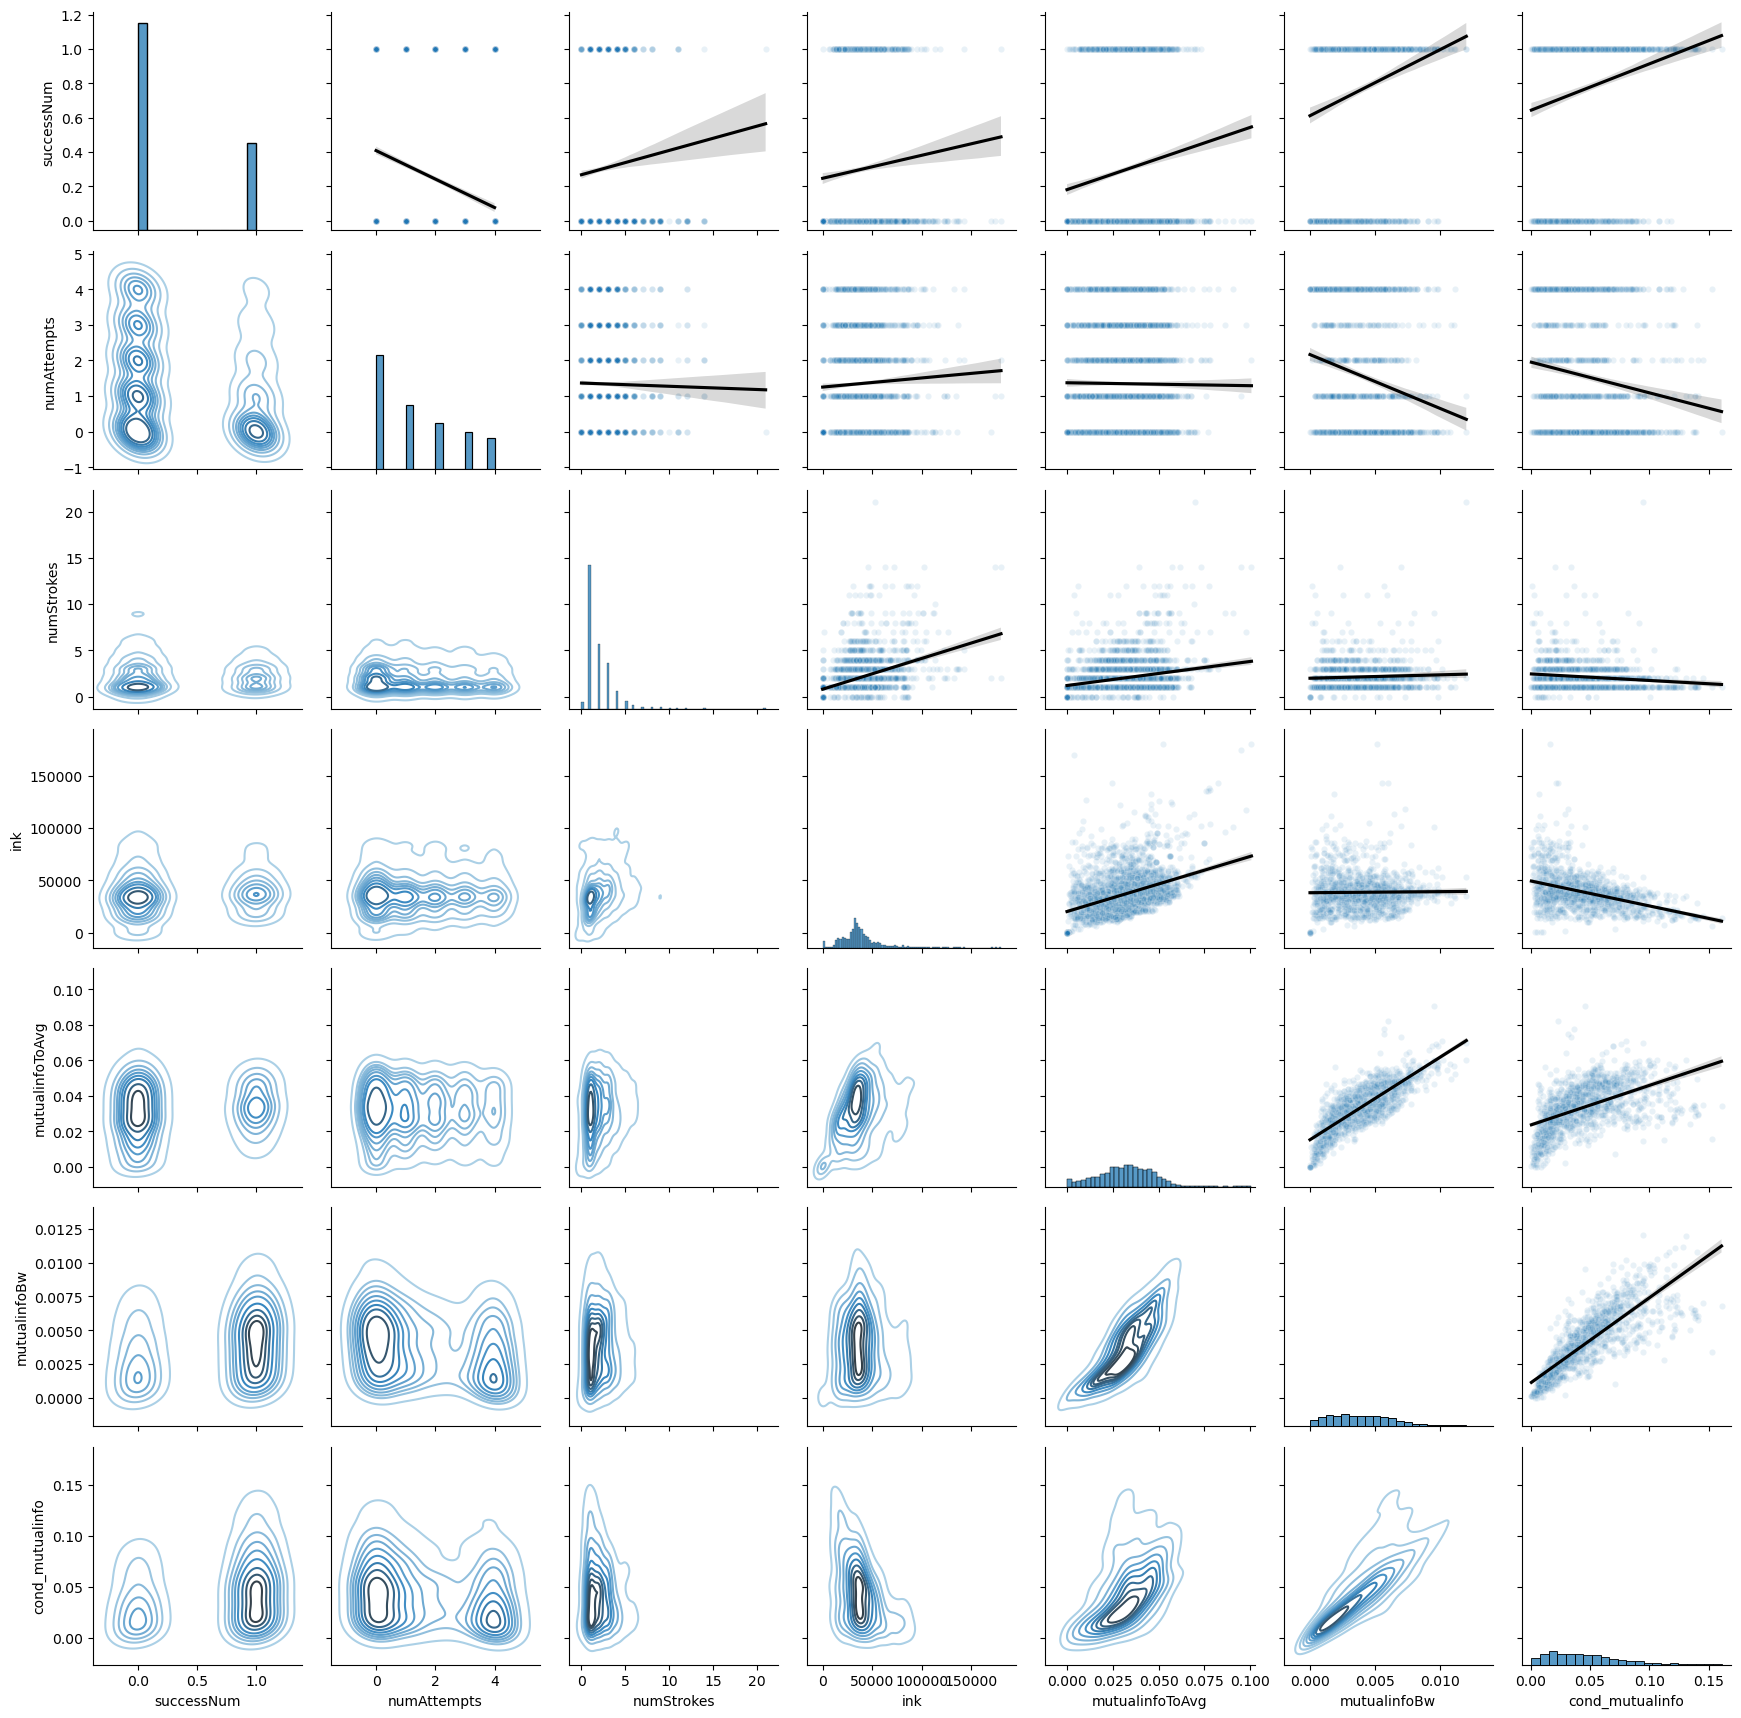

In [63]:
trialmeasures = (
    trials
    .assign(successNum = (trials['success'] == 'success').astype(int))
    .loc[:, ['successNum','numAttempts','numStrokes','ink','mutualinfoToAvg','mutualinfoBw','cond_mutualinfo']]
)
    
# trialmeasures
g = sns.PairGrid(trialmeasures)
g.map_diag(sns.histplot)
g.map_upper(sns.regplot, scatter_kws=dict(alpha=0.1, s=20, edgecolors='white'), line_kws=dict(color='black'))
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.savefig("fig/corrs.png")

# Compare between-subject conditions

In [64]:
# total participants between-subjects
subjsPerCond = (
    trials
    .drop_duplicates(subset=['trainingCond','subjID'])
    .groupby('trainingCond')
    .size()
    .reset_index(name='totalsubj')
)

# look at success rate
# (
#     trials
#     .query('trialPart == "training"')
#     .groupby(['trainingCond', 'subjID', 'levelID', 'gravX'])
#     .apply(lambda x: x.query("numAttempts == numAttempts.max()"))
#     .reset_index(drop=True)
#     .groupby(['trainingCond','levelID','gravX','success'])
#     .size()
#     .reset_index(name='numOutcome')
#     .merge(subjsPerCond, how="left", on="trainingCond")
# )

In [65]:
# compare mutual information across conditions, trialPart
(
    trials
    .dropna()
    .groupby(['trainingCond','trialPart'])
    .agg({'cond_mutualinfo': ['mean','var'],
          'mutualinfoBw': ['mean','var'], 
          'mutualinfoToAvg': ['mean','var'],
          'numStrokes': ['mean','var'],
          'ink': ['mean','var'],
          'numAttempts': ['mean','var']})
)

cond_mutualinfo           mutualinfoBw            \
                                  mean       var         mean       var   
trainingCond trialPart                                                    
narrow       critical         0.047151  0.001287     0.004206  0.000009   
             training         0.040415  0.000562     0.003987  0.000005   
wide         critical         0.040675  0.001170     0.003594  0.000007   
             training         0.048973  0.000925     0.003914  0.000004   

                       mutualinfoToAvg           numStrokes            \
                                  mean       var       mean       var   
trainingCond trialPart                                                  
narrow       critical         0.035376  0.000234   2.444444  4.264889   
             training         0.034355  0.000198   2.529289  2.400608   
wide         critical         0.032460  0.000209   2.232704  4.939177   
             training         0.032868  0.000117   1.734558  1.285610   

                                 ink               numAttempts            
                                mean           var        mean       var  
trainingCond trialPart                                                    
narrow       critical   39272.000000  2.773104e+08    2.253968  3.166984  
             training   42771.690377  3.533220e+08    1.916318  2.974115  
wide         critical   40100.433962  3.744583e+08    2.591195  2.749542  
             training   35022.846411  2.077285e+08    0.873122  1.833373

/Users/lo2069/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


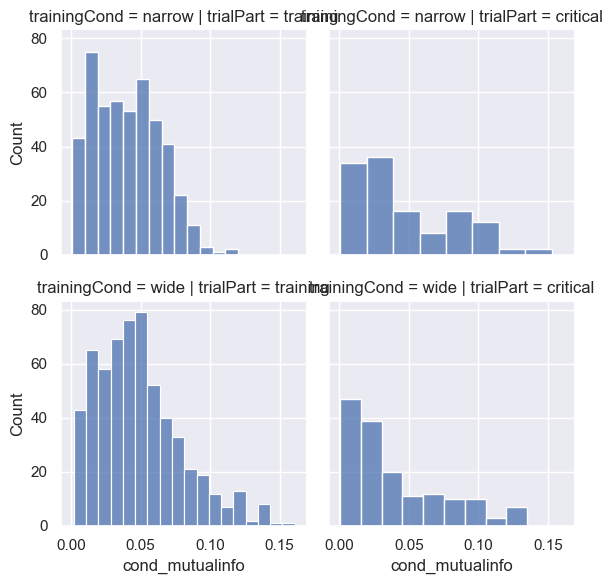

In [66]:
# histogram of cond_mutualinfo
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(trials.dropna(), col="trialPart", row="trainingCond")
g.map(sns.histplot, "cond_mutualinfo")

/Users/lo2069/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


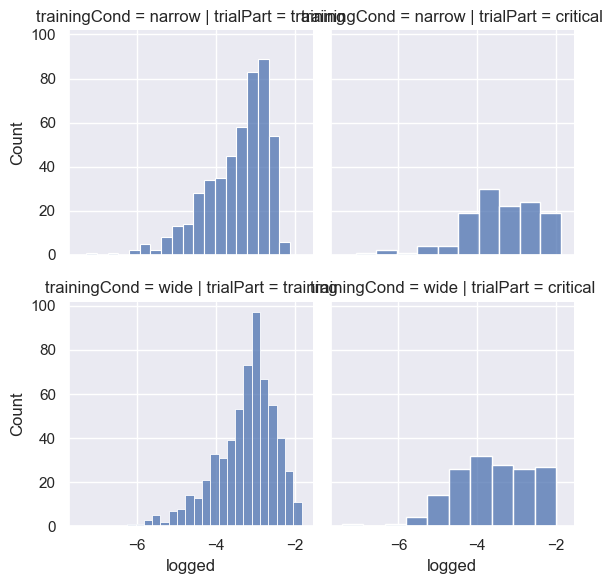

In [68]:
# histogram of logged cond_mutualinfo --> though perhaps this should be logit to normalize proportion
sns.set_theme(style="darkgrid")
g = sns.FacetGrid(trials.dropna().assign(logged = np.log(trials['cond_mutualinfo'])), 
                  col="trialPart", row="trainingCond")
g.map(sns.histplot, "logged")

In [72]:
# get training mutual info mean
trainingMIdf = (
    trials
    .query('trialPart == "training"')
    .dropna()
    .groupby(['trainingCond','subjID'])
    .agg({'cond_mutualinfo': 'mean'})
)

# get training trial success
trainingCt = (
    trials
    .assign(successNum = (trials['success'] == 'success').astype(int))
    .query('trialPart == "training"')
    .dropna()
    .groupby(['trainingCond','subjID'])
    .agg({'successNum': 'sum'})
    .reset_index()
    .rename(columns={'successNum': 'trainingSuccess'})
)

# get critical trial success
# for each trial
successdf = (
    trials
    .assign(successNum = (trials['success'] == 'success').astype(int))
    .query('trialPart == "critical"')
    .dropna()
    [['trainingCond','subjID','levelID','successNum']]
)

# aggregated : proportion of success
successaggdf = (
    successdf
    .groupby(['trainingCond', 'subjID'])
    .agg({'successNum': 'sum'})
)


/Users/lo2069/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


,cond_mutualinfo,successNum
cond_mutualinfo,1.000000,-0.048012
successNum,-0.048012,1.000000


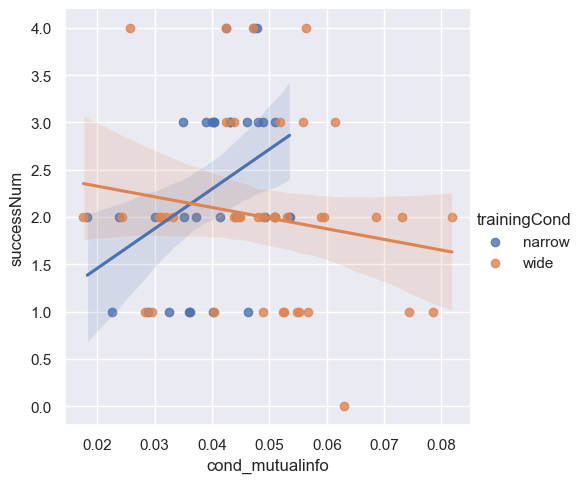

In [73]:
mergeagg = (
    trainingMIdf
    .merge(successaggdf, how='left', on=['trainingCond','subjID'])
)

sns.lmplot(data=mergeagg.reset_index(), x='cond_mutualinfo', y='successNum', hue='trainingCond')
mergeagg.corr(method='pearson')

In [74]:
trainingSucc = (
    trainingMIdf
    .merge(successdf, how='left', on=['trainingCond','subjID'])
    .merge(trainingCt, how='left', on=['trainingCond','subjID'])
)
trainingSucc.to_csv("dfs/trainingSucc.csv")

# Pull out trials human rating

In [75]:
trainingRate = (
    trials
    .dropna()
    .query('trialPart == "training" and ink > 1000')
    .query('subjID not in ["connect-BA366CE24A6245D0BFF165BA41E4F395", "connect-1D9FDFC8331148438004EEADB3CD9487", "connect-377EB0CE09C14DF8AFA6145368FF376B"]')
    .sort_values('ink')
)
# remove subjects with missing images

In [76]:
(
    trainingRate
    .groupby(['levelID', 'gravX'])
    .nunique()
    [['subjID']]
)

subjID
levelID          gravX        
basic_far        -0.25      38
                  0.00      38
                  0.25      38
basic_short      -0.25      38
                  0.00      38
                  0.25      38
basic_steep      -0.25      38
                  0.00      38
                  0.25      37
block_long       -0.25      30
                  0.00      31
                  0.25      31
block_med        -0.25      31
                  0.00      31
                  0.25      31
boomerang_middle -0.25      31
                  0.00      31
                  0.25      31
contain_corner   -0.25      31
                  0.00      31
                  0.25      31
diagonal_descent -0.25      31
                  0.00      31
                  0.25      31
tunnel_narrow    -0.25      38
                  0.00      38
                  0.25      38
tunnel_wide      -0.25      38
                  0.00      38
                  0.25      38

<Axes: xlabel='cond_mutualinfo', ylabel='ink'>

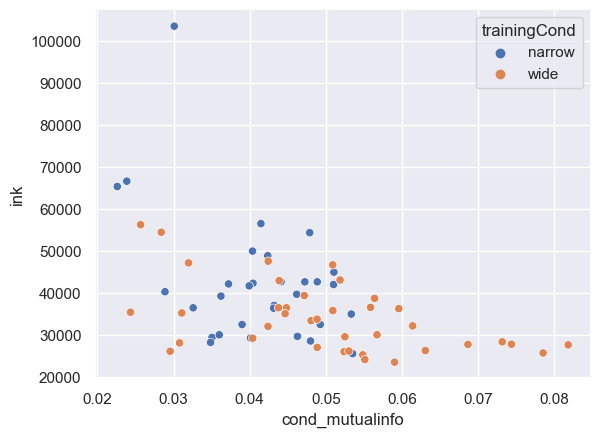

In [97]:
# sample images
subjAvgCondMI = (
    trainingRate
    .groupby(['trainingCond', 'subjID'])
    .agg({'cond_mutualinfo':'mean', 'ink':'mean'})
)

sns.scatterplot(subjAvgCondMI.reset_index(), x='cond_mutualinfo', y='ink', hue='trainingCond')

## wide condition sample -- gather representative sample

In [271]:
subsamp = int(30 / 6)

### sample from kmeans clusters for each condition?

In [278]:
fullWideSubjs = (
    trainingRate
    .query('levelID == "basic_steep" and gravX == 0.25')
    .subjID
)

/Users/lo2069/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<Axes: xlabel='cond_mutualinfo', ylabel='ink'>

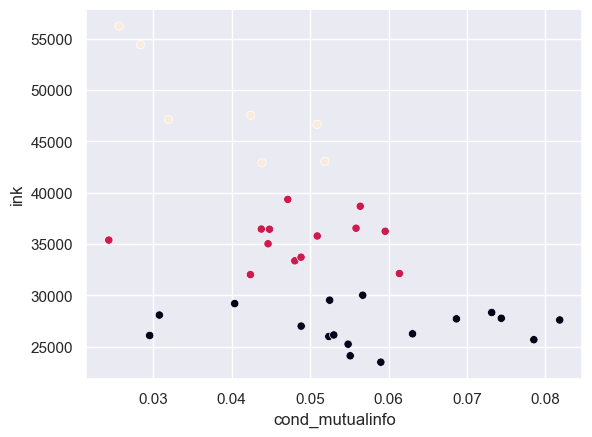

In [216]:
from sklearn.cluster import KMeans

wideCondMi = (
    subjAvgCondMI
    .query('subjID.isin(@fullWideSubjs)')
)

kmeans = KMeans(n_clusters=3)
kmeans.fit(wideCondMi)

sns.scatterplot(wideCondMi, x="cond_mutualinfo",y="ink", c=kmeans.labels_)

In [279]:
# extract tertiles for wide condition
# len(wideCondMi)
# n = 37

wideTertiles = np.quantile(wideCondMi.cond_mutualinfo, [0,0.33,0.67,1])
wideTertiles

array([0.02433917, 0.04480039, 0.05520145, 0.08181498])

In [280]:
# since total size = 31, sample 10 from middle tertile and add to others
wideFirstTertile = (
    wideCondMi
    .query('cond_mutualinfo <= @wideTertiles[1]')
    .sample(n=subsamp, random_state=88888) #set seed
)

wideMidTertile = (
    wideCondMi
    .query('cond_mutualinfo > @wideTertiles[1] and cond_mutualinfo <= @wideTertiles[2]')
    .sample(n=subsamp, random_state=888888) # set seed
)

wideLastTertile = (
    wideCondMi
    .query('cond_mutualinfo > @wideTertiles[2]')
    .sample(n=subsamp, random_state=8888888) # set seed
)

wideSubjSample = pd.concat([wideFirstTertile, wideMidTertile, wideLastTertile])

In [281]:
wideSubjs = wideSubjSample.reset_index().subjID

wideSample = (
    trainingRate
    .query('subjID.isin(@wideSubjs)')
)

## narrow condition sample -- gather representative sample

In [289]:
# if gathering 30 participants and only removing one
# narrowSubjs = (
#     trainingRate
#     .query('levelID == "block_long" and gravX == -0.25')
#     .subjID
# )

# narrowSample = (
#     trainingRate
#     .query('subjID.isin(@narrowSubjs)')
# )

fullNarrowSubjs = (
    trainingRate
    .query('levelID == "block_long" and gravX == -0.25')
    .subjID
)

narrowCondMi = (
    subjAvgCondMI
    .query('subjID.isin(@fullNarrowSubjs)')
)

narrowTertiles = np.quantile(narrowCondMi.cond_mutualinfo, [0,0.33,0.67,1])

# since total size = 31, sample 10 from middle tertile and add to others
narrowFirstTertile = (
    narrowCondMi
    .query('cond_mutualinfo <= @narrowTertiles[1]')
    .sample(n=subsamp, random_state=88888) #set seed
)

narrowMidTertile = (
    narrowCondMi
    .query('cond_mutualinfo > @narrowTertiles[1] and cond_mutualinfo <= @narrowTertiles[2]')
    .sample(n=subsamp, random_state=888888) # set seed
)

narrowLastTertile = (
    narrowCondMi
    .query('cond_mutualinfo > @narrowTertiles[2]')
    .sample(n=subsamp, random_state=8888888) # set seed
)

narrowSubjSample = pd.concat([narrowFirstTertile, narrowMidTertile, narrowLastTertile])

narrowSubjs = narrowSubjSample.reset_index().subjID
narrowSample = (
    trainingRate
    .query('subjID.isin(@narrowSubjs)')
)

In [295]:
[narrowSubjs, wideSubjs]

[0     connect-DE8DEC42101C48DEAF5B12C04FCE8999
 1     connect-D04F6CB04CD04617BC6683C605093ECB
 2     connect-F6C2C2975E2D47A29BB1DC4817243718
 3     connect-583B48DB907C40209E1A17E7E6700800
 4     connect-512FED05A72842BF9658B966FBD7F076
 5     connect-0CF3DCDB98DC44B49C405E0A04B920BD
 6     connect-F49895A417FF41E8B964A363224BB377
 7     connect-9E996302D5244260878FDB74CBB316F4
 8     connect-39EA9FD515844207B3DA47AA34B2A2CF
 9     connect-EA1DDBB0D9E5471381D5FD3553DC8E12
 10    connect-8AD70996DA284ECB828016DC41BD81FE
 11    connect-744714E340DB43A9BF547F27A1FC506D
 12    connect-85C92CDBAC71452684E2566DAB6C7342
 13    connect-63D7B418580149AF98F4124345C6DCA0
 14    connect-CE387251FBBC45A58D6920EB0935069A
 Name: subjID, dtype: object,
 0     connect-9D77BFB713434C959919E681D5AA3E24
 1     connect-3BFBDC65C28E4B2FA8EDA187DB8AC711
 2     connect-BE75C28233BF4FC2B473BC240E3A6CEC
 3     connect-75B7E17B71B840568DF71AE43662AD2D
 4     connect-87EE41F6127E4C2DB97D61F7BF43047D
 5     con

In [290]:
imageSample = pd.concat([narrowSample, wideSample])
imageSample.to_csv("dfs/imageSample.csv")

In [323]:
# check that I have 30 x 15 = 900 unique images
len(imageSample)

(
    imageSample
    .nunique()
    [['imageID']]
)

imageID    450
dtype: int64

In [334]:
# develop json version of levelID x gravX x imageID
import json

sampleImgDict = {}

for l in imageSample['levelID'].unique():
    for g in imageSample['gravX'].unique():
        # convert gravX to directional text
        if g == -0.25:
            gtxt = "left"
        elif gtxt == 0.25:
            g = "right"
        elif g == 0.00:
            gtxt = "none"
        # dictionary key that is directory
        directory = l + "-" + gtxt
        
        # query relevant subset of dataframe for level and gravX
        subdf = (
            imageSample
            .query("levelID == @l and gravX == @g")
        )
        
        # create dictionary entry with value as array of imageIDs
        sampleImgDict[directory] = subdf.imageID.tolist()
        

with open("dfs/imagesRate.json", "w", encoding="utf-8") as outfile:
    json.dump(sampleImgDict, outfile, indent=4)

## Remove End Point in Image Stimuli

In [292]:
from functools import reduce

# function removes marble
def toRating(image):
    # convert image to numpy array
    img_array = np.array(image)
    
    # change marble color
    
    marble_color = np.array([150, 125, 227, 255])
    marble_match = np.all(img_array == marble_color, axis=-1)
    img_array[marble_match] = [128, 0, 128, 255] # Dark Purple
    
    
    # define colors that will not be changed
    cup = [0, 0, 0, 255]
    new_marble = [128, 0, 128, 255]
    wind = [255, 255, 255, 255]
    strokes = [0, 170, 0, 255]
    # not using these colors because I am hiding these objects
    # marble_color = [98, 76, 219, 255]
    # innercup = [211, 211, 211, 255]
    
    
    # convert each array into np.array
    target_colors = [cup, new_marble, wind, strokes]
    target_colors = [np.array(color) for color in target_colors]
    
    # check if color
    matches = [np.all(img_array == color, axis=-1) for color in target_colors]
    
    mask = reduce(np.logical_or, matches)
    
    # set pixels not matching the target color to blue
#     img_array[~mask] = [0, 0, 139, 255]  # Blue
    img_array[~mask] = [170, 170, 170, 255]  # Gray

    # convert the NumPy array back to an image
    result_img = Image.fromarray(img_array[60:])
    
    return result_img

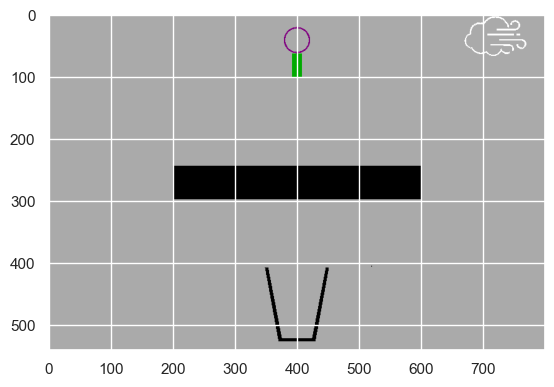

In [241]:
img = Image.open("../../game1/data/img/expt/connect-85C92CDBAC71452684E2566DAB6C7342/connect-85C92CDBAC71452684E2566DAB6C7342_img21.png")
new_img = toRating(img)

imgplot = plt.imshow(new_img)
plt.show()

In [294]:
rateDict = {}
for s in range(len(imageSample)):
    # get row in image sample df
    samplerow = imageSample.iloc[s]
    
    # open image from file
    img = Image.open("../../game1/data/img/expt/"+samplerow.subjID+"/"+samplerow.imageID)
    
    # convert image to remove image details
    new_img = toRating(img)
    
    # save edited images to dictionary
    rateDict[imageID] = new_img
    
    # get level + gravX info
    level = samplerow.levelID
    gravX = samplerow.gravX
    if gravX == -0.25:
        wind = 'left'
    elif gravX == 0.00:
        wind = 'none'
    elif gravX == 0.25:
        wind = 'right'
    directory = '../../game2/assets/stim/'+level+'-'+wind+'/'
    if not os.path.exists(directory):
        os.makedirs(directory)

    new_img.save(directory+samplerow.imageID)